# Tutorial for Exploring the Correlational Structure Present in Spontaneous Activity Patterns of the Ferret Visual Cortex

### Last updated by David Whitney on 2/27/2019
david.whitney@mpfi.org

**Overview**: As part of a CRCNS grant shared between the Fitzpatrick and Kaschube labs, we are excited to provide public access to an in vivo calcium imaging dataset of GCAMP6s. The time series dataset contains 10 minutes of spontaneous activity recorded with widefield epifluorescence imaging from the visual cortex of a lightly anesthetized ferret (43 days old). We also include a brief tutorial of Python code that can be used to explore the dataset. For this tutorial, we will demonstrate that spontaneous activity in the ferret visual cortex exhibits long-range correlated activity, and that these correlations strongly predict the layout of visually evoked orientation columns. Data acquired from this collaboration recently resulted in a published manuscript at [Nature Neuroscience](https://www.nature.com/articles/s41593-018-0247-5).  

**Dataset Details:** [The time series dataset can be downloaded here](https://cloud.mpfi.org/url/nh5r72pri3fp4qxx). Imaging frames (640x540) were originally acquired using an Andor sCMOS camera at 15Hz, but to reduce the dataset size below 100MB we have temporally binned the imaging dataset down to 3Hz and spatially binned frames by 4x (160x135). Downsampling should only minimally affect the spontaneous activity patterns contained in this dataset. Imaging frames have been converted from raw fluorescence units to ΔF/F0. The baseline F0 for each pixel was obtained by applying a rank-order filter to the raw fluorescence trace with a rank of 15 and a time-window of 30s. A ROI mask was manually drawn around the cortical region with high, robust visually evoked activity. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from Spontaneous import Spontaneous
from OPM import OPM
%matplotlib inline

# Load the spontaneous activity sample dataset. The folder path must point to the location spont_data.mat
folder_path = os.getcwd()
test_obj = Spontaneous(folder_path)
print('Current working directory: {}'.format(os.getcwd()))

Current working directory: G:\Python\spontaneousData\pythonCode\IpythonNotebook


If a warning was issued that a file named spont_time_series.zip could not be found, then the time-series dataset needs to be downloaded to the current working directory (see link above). However, for the purposes of this tutorial, this file is not necessary to proceed to subsequent steps. 

All of the data necessary for this tutorial can be accessed in a Python dictionary located in the test_obj object (relative path: test_obj.data) or in the spont_data.mat file. The available keys are:
* 'spont_event_frames': a 3d numpy array (nFrames,x,y) containing the active frames
* 'mask': The ROI mask
* 'mean_time_series_trace_3Hz': Mean fluorescence of the ROI mask across the downsampled time series (3Hz)
* 'spont_event_frameIDs_3Hz': IDs of active frames for the downsampled dataset (3Hz)
* 'frame_timestamps_3Hz': Elapsed frame times of the downsampled time-series (3Hz)
* 'spont_time_series_3Hz': A 3d numpy array (nFrames,x,y) containing the downsampled fluorescence time series dataset. Only available if the spont_time_series.zip is downloaded.
* 'spont_event_frameIDs_15Hz': IDs of active frames from the original dataset (15Hz)
* 'mean_time_series_trace_15Hz': Mean fluorescence of the ROI mask across the original time series (15Hz)
* 'frame_timestamps_15Hz': Elapsed frame times of the original time-series (15Hz)

In [2]:
test_obj.data.viewkeys()

dict_keys(['mean_time_series_trace_3Hz', 'spont_time_series_3Hz', 'frame_timestamps_15Hz', 'mask', '__header__', '__globals__', 'spont_event_frames', 'spont_event_frameIDs_15Hz', 'mean_time_series_trace_15Hz', 'spont_event_frameIDs_3Hz', '__version__', 'frame_timestamps_3Hz'])

## In vivo spontaneous activity patterns in ferret visual cortex

Here we will look at active periods of spontaneous activity during the 10 minute time-series. Active frames are defined as periods with a spatially extended pattern of activity (> 80% of pixels were active). Consecutive active frames are combined into a single event starting with the first high-activity frame and then either ending with the last high-activity frame or, if present, an activity frame defining a local minimum in the fluorescence activity.

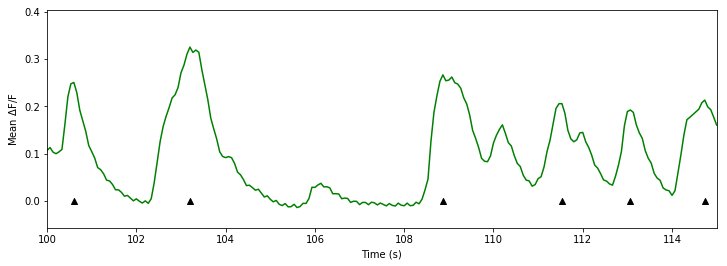

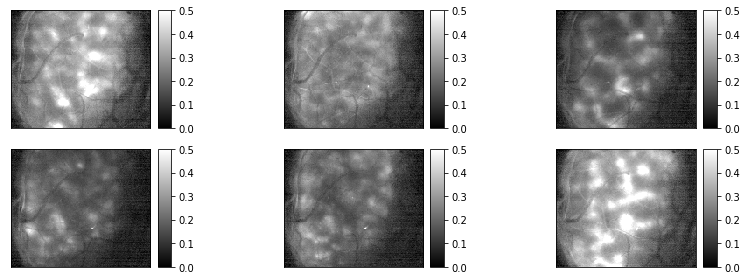

In [3]:
# Get event data for a small time window (15s) in the imaging stack. The time-window by default starts at 100s and ends at 115s.
time_window = [100,115] # in seconds
time_window = [time_window[i]*15 for i in range(2)]
event_frame_IDs  = test_obj.data['spont_event_frameIDs_15Hz'].flatten()
time_stamps      = test_obj.data['frame_timestamps_15Hz'].flatten()
mean_fluor_trace = test_obj.data['mean_time_series_trace_15Hz'].flatten()
event_loc = 0 * time_stamps
event_loc[event_frame_IDs] = 1+np.arange(len(event_frame_IDs))
unique_events = np.unique(event_loc[time_window[0]:time_window[1]])[1:].astype('int16')
n_uniq_events = len(unique_events)

# Show the average fluorescence changes of the time-series for a 15s window. Active frames are denoted by the black triangles.
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(time_stamps, mean_fluor_trace, 'g') 
[ax.scatter(time_stamps[i],0,marker = '^', color = 'black') for i in range(len(time_stamps)) if event_loc[i]>0]
ax.set_ylabel('Mean $\Delta$F/F')
ax.set_xlabel('Time (s)')
ax.set_xlim([time_window[0]/15.,time_window[1]/15.])

# Now include the activity patterns for the active frames at the bottom.
nrows = 2.;
ncols = np.floor(n_uniq_events/nrows)
fig, axes = plt.subplots(nrows=np.int(nrows),ncols=np.int(ncols),figsize=(12,4))
axes = axes.flatten()
for index in range(n_uniq_events):
    # Show the active frame
    ax = axes[index]
    im = ax.imshow(test_obj.data['spont_event_frames'][unique_events[index],:,:], cmap='gray', vmin=0, vmax=0.5)
    ax.set_xticks([])
    ax.set_yticks([])

    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.10)
    fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()

To assess the spatial correlation structure of spontaneous activity, we next applied a Gaussian spatial high-pass filter to the active frames of spontaneous activity (with s.d. of Gaussian filter kernel shigh = 195 µm). We can observe the effect of this spatial filtering on the previously shown spontaneous activity patterns.

Spontaneous.py:80: RuntimeWarning: invalid value encountered in divide
  /snd.gaussian_filter(mask.astype(event_frame.dtype),sigma,mode='constant',cval=0)


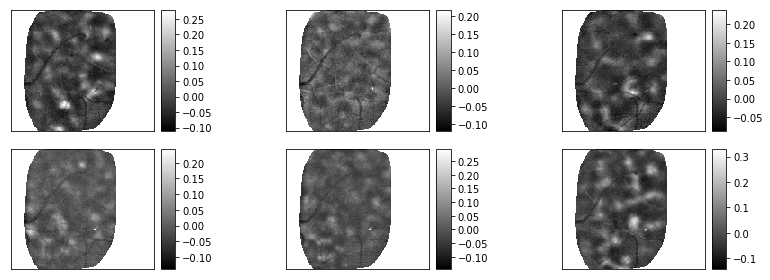

In [4]:
spatial_resolution = 4000/153. # in microns per pixel
test_obj.spatial_filter_events(sigma=np.round(195/spatial_resolution))
fig, axes = plt.subplots(nrows=np.int(nrows),ncols=np.int(ncols),figsize=(12,4))
axes = axes.flatten()
for index in range(n_uniq_events):
    # Show the active frame
    ax = axes[index]
    im = ax.imshow(test_obj.data['spont_event_frames'][unique_events[index],:,:], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.10)
    fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()

## Spontaneous correlation patterns exhibit long-range structure across the entire field-of-view.

After spatial filtering, all of the active frames are used to compute the spontaneous correlation patterns as the pairwise Pearson’s correlation between all locations x within the ROI and a seed point.

211 active frames used for computing correlation


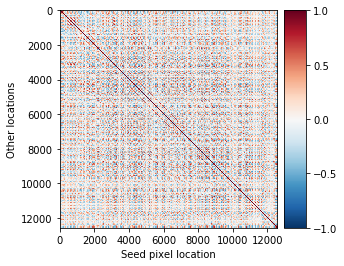

In [5]:
# Compute all possible pairwise correlations between pixels
corrTable = test_obj.get_correlation_table();
BuRd = test_obj.get_colormap();
fig,ax = plt.subplots()
im=ax.imshow(corrTable,cmap=BuRd,vmin=-1,vmax=1)
ax.set_ylabel('Other locations')
ax.set_xlabel('Seed pixel location')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.10)
fig.colorbar(im, cax=cax, ticks=[-1,-0.5,0,0.5,1], orientation='vertical')
print('{} active frames used for computing correlation'.format(len(event_frame_IDs)))

The correlation table by itself is not yet very informative, but we can reconstruct an individual spontaneous correlation pattern from taking a single column entry of the correlation table to reconstuct an image.

Text(0.5,1,'Seed location: [55,55]')

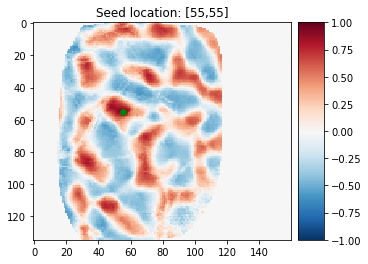

In [6]:
# Show a correlation pattern at given seed point (green point)
fig,ax = plt.subplots()
startValues=[55,55]
corrPattern=test_obj.get_correlation_pattern(startValues)
im=ax.imshow(corrPattern,cmap=BuRd,vmin=-1,vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.10)
fig.colorbar(im, cax=cax, orientation='vertical')
seedPt=ax.plot(startValues[0],startValues[1],'og')[0]
ax.set_title("Seed location: [{X},{Y}]".format(X=startValues[0],Y=startValues[0]))

Now we can interactively alter the x and y locations of the seed point to construct different spontaneous correlation patterns from the correlation table.

In [7]:
#%%capture
#%matplotlib inline
from ipywidgets import interact, widgets
from IPython.display import display

print("Select seed point location (x,y)")
def interativePlot(fig,ax,im,seedPt):
    # Add an interactive widget, so we can alter the correlation pattern
    def changeCorrPatternFunc(x,y):
        corrPattern=test_obj.get_correlation_pattern([x,y])
        im.set_data(corrPattern)
        ax.set_title("Seed location: [{X},{Y}]".format(X=x,Y=y))
        seedPt.set_xdata(x)
        seedPt.set_ydata(y)
        fig.canvas.draw()
        display(fig);

    # Show initial correlation pattern
    [h,w]=test_obj.mask.shape
#    interact(changeCorrPatternFunc,x=widgets.IntSlider(min=1,max=w,step=1,value=startValues[0]),\
#                                   y=widgets.IntSlider(min=1,max=h,step=1,value=startValues[1]))
    interact(changeCorrPatternFunc,x=widgets.BoundedIntText(value=startValues[0],min=1,max=w,step=1,description='x:'),\
                                   y=widgets.BoundedIntText(value=startValues[1],min=1,max=h,step=1,description='y:'))
interativePlot(fig,ax,im,seedPt)

Select seed point location (x,y)


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEJvdW5kZWRJbnRUZXh0KHZhbHVlPTU1LCBkZXNjcmlwdGlvbj11J3g6JywgbWF4PTE2MCwgbWluPTEpLCBCb3VuZGVkSW50VGV4dCh2YWx1ZT01NSwgZGXigKY=


## Relationship of spontaneous correlation patterns to the orientation preference map

In addition to the spontaneous activity dataset, we also provide trial-averaged single-condition responses to drifting gratings presented at different directions of motion.

In [8]:
# Load our sample dataset
ori_obj = OPM(folder_path)

OPM.py:74: RuntimeWarning: invalid value encountered in divide
  /snd.gaussian_filter(mask.astype(diffMaps[i].dtype),sigma,mode='constant',cval=0)


All of the evoked data can be accessed in a Python dictionary located in the ori_obj object (relative path: ori_obj.data) or in the opm_data.mat file. The followings keys can be used:
* 'scms': a 3d numpy array (x,y,nConds) containing the trial-averaged single-condition response images to different stimulus directions
* 'mask': The ROI mask
* 'stim_directions': Direction of motion of the unidirectionally drifting gratings. 
* 'spatial_resolution': spatial resolution (microns per pixel)

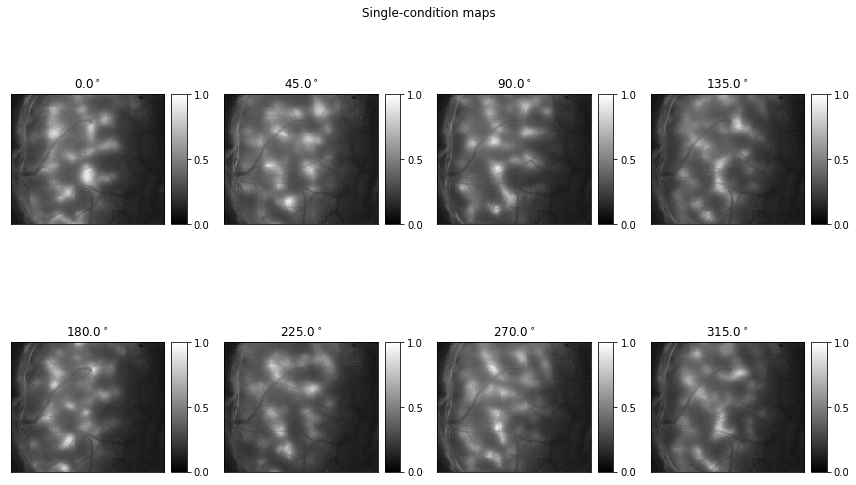

In [9]:
# Show the trial-averaged single condition maps
stim_directions = np.squeeze(ori_obj.data['stim_directions'])
n_conds = len(stim_directions)
[fig,axes]=plt.subplots(nrows=2,ncols=np.ceil(n_conds/2.).astype('int16'),figsize=(12,8))
fig.suptitle('Single-condition maps')
for i, ax in enumerate(axes.flatten()):
    # Plot single-condition map
    im=ax.imshow(ori_obj.data['scms'][:,:,i],cmap='gray',vmin=0,vmax=1.0)
    ax.set_title('{}$^\circ$'.format(stim_directions[i]))
    ax.set_xticks([])
    ax.set_yticks([])

    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.10)
    fig.colorbar(im,cax=cax, ticks=np.arange(0,1.01,0.5), orientation='vertical')
fig.tight_layout()
plt.show(block=True)

From the trial-averaged single-condition maps, we can calculate the preferred orientation of each pixel using a vector sum.

OPM.py:83: RuntimeWarning: invalid value encountered in remainder
  normalized_opm = np.mod(np.angle(self.opm),2*np.pi)/(2*np.pi)
C:\ProgramData\Anaconda2\envs\py27\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


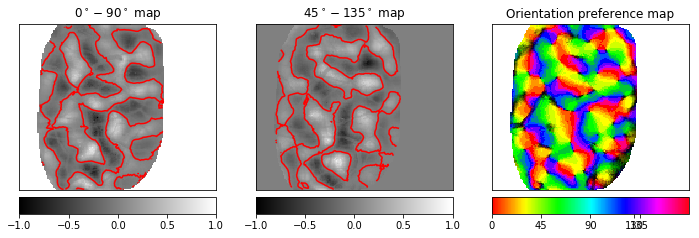

In [10]:
# Show the orientation preference map with zero-crossings contours (red)
(fig,axes)=plt.subplots(nrows=1,ncols=3,figsize=(12,8))
for i,ax in enumerate(axes):
    if(i==0):
        ticks=[-1,-0.5,0,0.5,1]
        im=ax.imshow(np.real(ori_obj.opm),cmap='gray',vmin=-1,vmax=1)
        ori_obj.addOPMContours(ax,angles=[0],colors='red')
        ax.set_title('$0^\circ-90^\circ$ map')
    elif(i==1):
        ticks=[-1,-0.5,0,0.5,1]
        im=ax.imshow(np.imag(ori_obj.opm),cmap='gray',vmin=-1,vmax=1)
        ori_obj.addOPMContours(ax,angles=[45],colors='red')
        ax.set_title('$45^\circ-135^\circ$ map')
    elif(i==2):
        ticks=[0,45,90,135,130]
        im=ax.imshow(ori_obj.get_OPM(),cmap='hsv',vmin=0,vmax=180)
        ax.set_title('Orientation preference map')
        
    ax.set_xticks([])
    ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="10%", pad=0.10)
    cbar = fig.colorbar(im,cax=cax, ticks=ticks, orientation='horizontal')

Text(0.5,1,'Seed location: [55,55], $\\theta=-52.2^\\circ$')

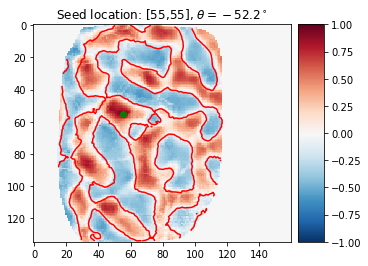

In [11]:
# Show a correlation pattern, but this time add the orientation contours at the preferred orientation of the seed pixel
fig,ax = plt.subplots()
startValues=[55,55]
corrPattern=test_obj.get_correlation_pattern(startValues)
im=ax.imshow(corrPattern,cmap=BuRd,vmin=-1,vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.10)
fig.colorbar(im, cax=cax, orientation='vertical')
seedPt=ax.plot(startValues[0],startValues[1],'og')[0]

# Add OR contours
preferredOri=np.angle(ori_obj.opm[startValues[1],startValues[0]])*90/np.pi
ori_obj.addOPMContours(ax,angles=[preferredOri],colors='red')
ax.set_title("Seed location: [{},{}], $\\theta={:3.1f}^\circ$".format(startValues[0],startValues[0],preferredOri))

Here we can clearly see a close correspondence between the layout of the orientaton preference map, and the spontaneous correlation structure. Another way to visualize this relationship is to sort the seed pixels in the correlation table by their preferred orientation.

In [12]:
# Sort the seed pixel IDs based on orientation tuning
sortedSeedPixels = np.argsort(np.angle(ori_obj.opm[test_obj.mask]))
sortedCorrTable = corrTable[sortedSeedPixels,:]
sortedCorrTable = sortedCorrTable[:,sortedSeedPixels]

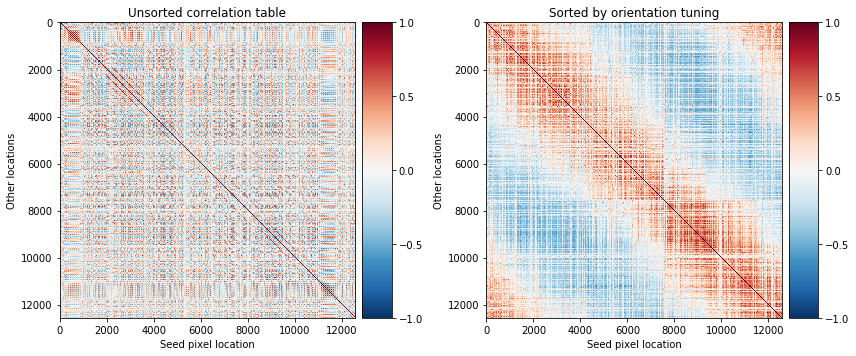

In [15]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,8))
col_names = ['Unsorted correlation table','Sorted by orientation tuning']
for [ax,title_name,table] in zip(axes,col_names,[corrTable,sortedCorrTable]):
    im=ax.imshow(table,cmap=BuRd,vmin=-1,vmax=1)
    ax.set_ylabel('Other locations')
    ax.set_xlabel('Seed pixel location')
    ax.set_title(title_name)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.10)
    fig.colorbar(im, cax=cax, ticks=[-1,-0.5,0,0.5,1], orientation='vertical')
fig.tight_layout()

After sorting the correlation table by orientation tuning, clusters of positive correlation are present between nearby pixel locations. This means that pixel locations with more similar orientation tuning are more strongly correlated in their spontaneous activity. Further analysis of this dataset was recently published at [Nature Neuroscience](https://www.nature.com/articles/s41593-018-0247-5). Thanks for joining us in this brief tutorial!